In [ ]:
!nvidia-smi

Sat Dec  7 11:16:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
from torchvision import datasets, transforms
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                             ])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

In [ ]:
#spliting the trainset into 80% training set and 20% validation set
train_num =int(len(trainset)*0.8)
val_num =len(trainset)-train_num
trainset,valset=torch.utils.data.random_split(trainset,[train_num,val_num])
len(trainset),len(valset)

(48000, 12000)

In [ ]:
#loading the data
train_loader=torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
val_loader=torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
test_loader=torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

torch.Size([64, 1, 28, 28]) torch.Size([64])
Trouser


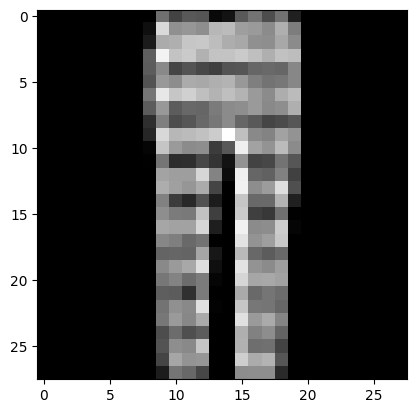

In [ ]:
dataiter=next(iter(train_loader))
images,labels=dataiter
print(images.shape,labels.shape)
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(classes[labels[0]])
plt.imshow(images[0].squeeze(), cmap='gray')# Squeeze the image to remove the channel dimension
plt.show()


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(trainset) / batch_size)
num_epochs = int(num_epochs)

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Non-linearity 1
        self.relu1 = nn.ReLU()

        # Linear function 2: 100 --> 100
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.relu2 = nn.ReLU()

        # Linear function 3: 100 --> 100
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.relu3 = nn.ReLU()

        # Linear function 4 (readout): 100 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)

        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.relu3(out)

        # Linear function 4 (readout)
        out = self.fc4(out)
        return out
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 28*28).requires_grad_().to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.3688867390155792. Accuracy: 80.2300033569336
Iteration: 1000. Loss: 0.6845625042915344. Accuracy: 81.95999908447266
Iteration: 1500. Loss: 0.48412448167800903. Accuracy: 84.66999816894531
Iteration: 2000. Loss: 0.1497209370136261. Accuracy: 84.91999816894531
Iteration: 2500. Loss: 0.21496039628982544. Accuracy: 85.62999725341797
Iteration: 3000. Loss: 0.28281915187835693. Accuracy: 85.9800033569336
Iteration: 3500. Loss: 0.2649548649787903. Accuracy: 86.41000366210938
Iteration: 4000. Loss: 0.48994797468185425. Accuracy: 85.80000305175781
Iteration: 4500. Loss: 0.36336779594421387. Accuracy: 86.43000030517578


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(trainset) / batch_size)
num_epochs = int(num_epochs)

class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.scale = embed_dim ** 0.5

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        w=torch.matmul(Q,K.T)/self.scale
        w=torch.softmax(w,dim=1)
        V = torch.matmul(w, V)
        return V
class MLPWithAttention(nn.Module):
    def __init__(self):
        super(MLPWithAttention, self).__init__()
        self.flatten = nn.Flatten()
        self.embedding = nn.Linear(28 * 28, 512)  # Embedding layer
        self.bn1 = nn.BatchNorm1d(512)  # Batch normalization
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # Dropout layer

        self.attention = SelfAttention(512)  # Self-Attention layer
        self.fc2 = nn.Linear(512, 128)  # Second dense layer
        self.bn2 = nn.BatchNorm1d(128)  # Batch normalization
        self.dropout2 = nn.Dropout(0.3)  # Dropout layer
        self.fc3 = nn.Linear(128, 10)  # Output layer

    def forward(self, x):
        # Flatten input image
        x = self.flatten(x)

        # Compute embeddings
        x = self.embedding(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        # Apply self-attention
        x = self.attention(x)

        # Fully connected layers
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)  # Raw logits for CrossEntropyLoss
        return x


# Replace FeedforwardNeuralNetModel with MLPWithAttention
model = MLPWithAttention()

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01  # Reduced learning rate for stability
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Use GPU for data if available
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate accuracy
            correct = 0
            total = 0
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)

                    # Update total and correct counts
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            model.train()  # Set model back to training mode

            # Print loss and accuracy
            print(f"Iteration: {iter}. Loss: {loss.item():.4f}. Accuracy: {accuracy:.2f}%")


Iteration: 500. Loss: 0.7318. Accuracy: 63.10%
Iteration: 1000. Loss: 0.6159. Accuracy: 66.65%
Iteration: 1500. Loss: 0.4628. Accuracy: 70.20%
Iteration: 2000. Loss: 0.4138. Accuracy: 70.96%
Iteration: 2500. Loss: 0.6070. Accuracy: 72.27%
Iteration: 3000. Loss: 0.3003. Accuracy: 73.46%
Iteration: 3500. Loss: 0.5483. Accuracy: 74.36%
Iteration: 4000. Loss: 0.3384. Accuracy: 75.31%
Iteration: 4500. Loss: 0.3838. Accuracy: 75.79%
